# 주린이의 주가 예측

In [2]:
import pandas as pd
import numpy as np
import urllib.parse
import matplotlib.pyplot as plt
from datetime import date, timedelta
import FinanceDataReader as fdr
from matplotlib import font_manager, rc
from scipy import stats
import plotly.express as px
from selenium import webdriver
import bs4
%matplotlib inline

In [3]:
# 투자심리선이란 최근 2주(10일) 동안 주가가 전일과 대비해서 상승한 일수와 하락한 일수를 계산하여 
# 상승 일수가 며칠이었는가에 대한 비율을 나타낸다. 
# 투자심리도가 75% 이상이면 과열상태로 판단하여 매도시점이 되고,
# 반대로 25% 이하일 경우 매수시점이 된다.

In [102]:
# 안전하게 코스피 시가총액 상위 10위 종목만 선정

# 웹브라우저 설정 및 브라우저 팝업
options = webdriver.ChromeOptions()
driverLoc = "C:/Users/김남덕/Desktop/KOPO/김효관/stddev/addon/chromedriver/chromedriver.exe"
# driverLoc = "C:/Users/kopo/Desktop/KND/김효관/addon/chromedriver/chromedriver.exe"
driver = webdriver.Chrome(executable_path=driverLoc, options=options)

# 웹페이지 파싱될때까지 최대 3초 기다림
driver.implicitly_wait(3)

# # 브라우저 열기
targetUrl = "https://finance.naver.com/sise/"
driver.get(targetUrl)

# 페이지 url 및 소스 가져오기
finalUrl = driver.current_url
pgSource = driver.page_source

# BS4로 웹크롤링
bsObj = bs4.BeautifulSoup(pgSource, "html.parser")
findAttr = bsObj.find(name = "table", attrs={"id":"siselist_tab_7"})
findPart = findAttr.find_all(name="a")

# 리스트에 종목 저장
stockNameList = []
for i in range(0, len(findPart)):
    stockNameList.append(findPart[i].text)

In [103]:
stockNameList

['삼성전자',
 'SK하이닉스',
 'NAVER',
 '카카오',
 '삼성전자우',
 'LG화학',
 '삼성바이오로직스',
 '현대차',
 '삼성SDI',
 '셀트리온']

In [104]:
# 종목 코드 찾기
kospi = fdr.StockListing('kospi')

In [105]:
# 추출된 종목 코드를 리스트에 담기
stockCodeList = []
for i in range(len(stockNameList)):
    name = kospi[kospi['Name'] == stockNameList[i]]
    stockCode = name.iloc[0][0]
    stockCodeList.append(stockCode)

In [106]:
stockCodeList

['005930',
 '000660',
 '035420',
 '035720',
 '005935',
 '051910',
 '207940',
 '005380',
 '006400',
 '068270']

In [107]:
# 종료일
endDate = date.today()

# 시작일
beginDate = endDate - timedelta(days=90)

In [110]:
# 지난 3개월 동안의 주식 정보 가져오기
def getStockData(stockCode, beginDate, endDate):
    if stockCode is None:
        print("주식 코드 오류")
        return None
    dataFrame = fdr.DataReader(stockCode, beginDate, endDate)
    return dataFrame

In [133]:
def investLineMethod(df):
    changeList = [] # 변동률(Change) 리스트
    investLineList = [] # 투자 심리선 리스트
    tradingDays = 10 # 2주(10일) 기간 세팅
    for i in range(len(df)):
        changeList.append(list(df.Change[i-tradingDays:i])) # 투자 심리선 지표를 만들기 위해 2주(10일)간의 변동률(Change) 정보를 10개씩 리스트로 나눠 담는다
    for changeList2 in changeList: # 10개씩 담긴 리스트안에서 
        if not changeList2: # 만약 값이 없다면
            investLineList.append(0) # 0으로 채운다
        else:
            plusList = [] # 수익이 나온 일자를 저장할 리스트 생성
            for changeVal in changeList2: 
                if changeVal > 0: # 수익이 나왔다면 
                    plusList.append(changeVal) # 리스트에 저장
            plusVal = len(plusList) # 투자심리선 공식 = 10일동안 상승일 수 / 10일 * 100
            changeVal = len(changeList2)
            investLine = plusVal / changeVal * 100
            investLineList.append(investLine) # 투자 심리선에 저장
    df['investLine']=investLineList
    return df['investLine']

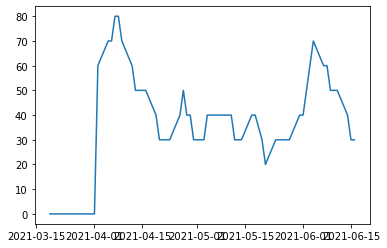

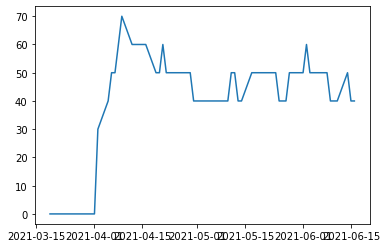

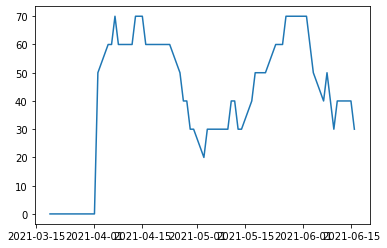

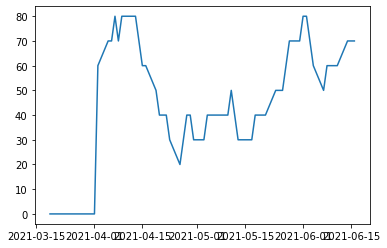

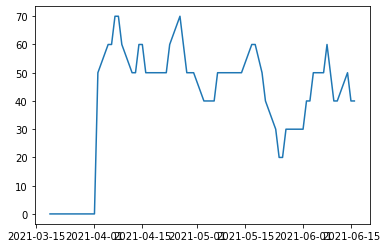

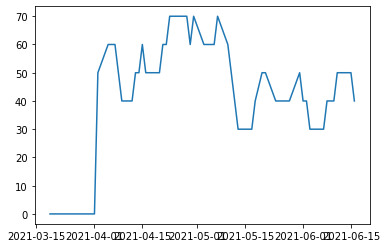

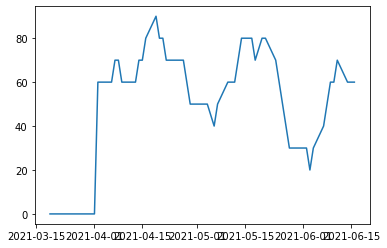

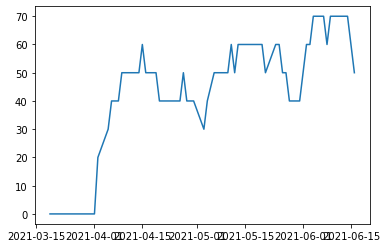

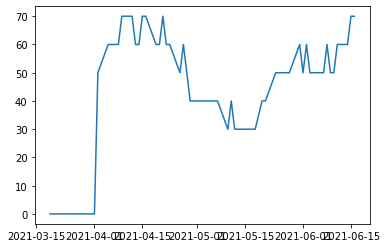

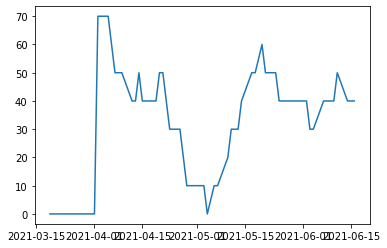

In [135]:
for i in stockCodeList:
    a = getStockData(i, beginDate, endDate)
    b = investLineMethod(a)
    plt.plot(b)
    plt.show()